In [1]:
import keras
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime  
import numpy as np
import re
import seaborn as sns

import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# all models 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# evaluating performance
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer

# functions for the convolutional neural network
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

# importing custom functions
from functions.custom_function_5 import tokenize_tweet
from functions.custom_function_5 import get_tokens_frequency_df
from functions.custom_function_5 import plot_roc_curve
from functions.custom_function_5 import calculate_performance
from functions.custom_function_5 import max_seq_length


Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/processed/data_for_modelling.csv')

The modelling notebook will be divided into the following sections:
    
1) Vectorization

2) Splitting of the initial dataset into Training/Validation/Set

3) Modelling with several iterations of a variety of models

4) Evaluation of winning model on the test set

# TF-IDF Vectorization

In order for models to understand raw text, one step that's necessary right before feeding the information to the algorithm is to vectorise all the text in our corpus. There are different ways to do this, the main two ones being the bag-of-words technique and the **tf-idf** method. The latter takes into account the 'rarity' of our words within the vocabulary and not only the frequency of occurence. In this specific context, tf-idf is a much better fit.

In the cell below, the max and minimum frequency of the document is set at respectively 0.9 and 2, taking into account only the most relevant 9000 words of our corpus. As explored in the EDA, we are taking into account n-grams up to three.

In [3]:
# instantiate the tf-idf object
tfidf_vectors = TfidfVectorizer(max_df=0.90, min_df=2, max_features=9000, 
                                stop_words='english',
                                ngram_range=(1, 3))



In this step, the matrix is not transformed yet since we need this object to make predictions on unseen text further down the pipeline of the project.
By pickling only the fit object we can iteratively transform each time new text on the base fit matrix. Unseen words will just be dropped whenever they are not in the original fit matrix below. 

In [4]:
tfidf_only_fit = tfidf_vectors.fit(df['tweet_without_stopwords_and_2'])

In [5]:
# pickling only the fit
pickle_out_only_fit = open('tfidf_pickle_fit', 'wb')
pickle.dump(tfidf_only_fit, pickle_out_only_fit)

In [6]:
# fitting and tranforming the matrix
tfidf = tfidf_vectors.fit_transform(df['tweet_without_stopwords_and_2'])

In [7]:
df_vector = pd.DataFrame(tfidf.todense(),columns = tfidf_vectors.get_feature_names())

# Splitting into Training/Validation/Test

This section just splits the initial dataset into three different subgroups, namely training, validation and test.
A stratified 10-fold obejct on teh training dataset will also later be created for further investigation and optimisation.

In [8]:
target = df['neg_label']


In [9]:
x_train, x_test, y_train , y_test = train_test_split(df_vector, target, 
                                                     test_size =.2, random_state=101 )

In [10]:
print(f'The shape of my training set is {x_train.shape}')
print(f'The shape of my training target is {y_train.shape}')
print(f'The shape of my test set is {x_test.shape}')
print(f'The shape of my test target is {y_test.shape}')

The shape of my training set is (33593, 9000)
The shape of my training target is (33593,)
The shape of my test set is (8399, 9000)
The shape of my test target is (8399,)


In [11]:
X_train, x_val, Y_train , y_val = train_test_split(x_train,y_train, 
                                                     test_size =.2, random_state=101 )

In [12]:
print(f'The shape of my final training set is {X_train.shape}')
print(f'The shape of my final training target is {Y_train.shape}')
print(f'The shape of my validation set is {x_val.shape}')
print(f'The shape of my validation target is {y_val.shape}')

The shape of my final training set is (26874, 9000)
The shape of my final training target is (26874,)
The shape of my validation set is (6719, 9000)
The shape of my validation target is (6719,)


# Logistic Regression Baseline

In [13]:
logmodel = LogisticRegression()

In [14]:
logmodel.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
calculate_performance(logmodel, x_val, y_val)

,f1,accuracy,roc_score,precision
0,0.973551,0.974252,0.995979,0.986981


In [16]:
calculate_performance(logmodel, X_train, Y_train)

,f1,accuracy,roc_score,precision
0,0.983148,0.98359,0.997736,0.992057


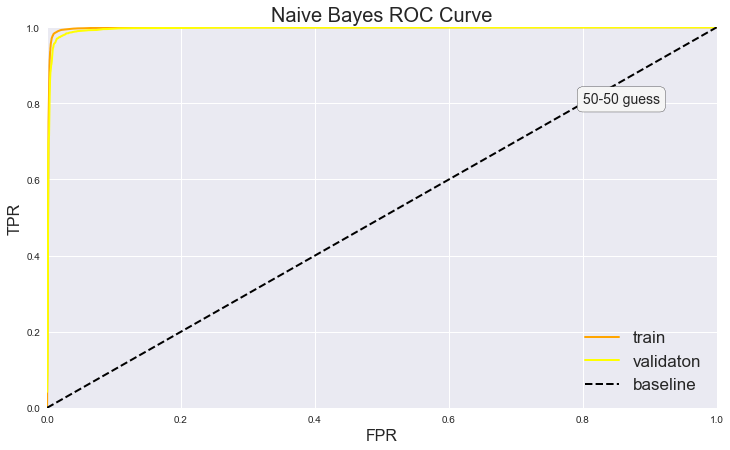

In [17]:
plot_roc_curve(logmodel, X_train, x_val, Y_train, y_val )

In [18]:
# testing on validation
y_hat_log = logmodel.predict(x_test)





In [19]:
f1_score(y_test, y_hat_log) # calculating f1 score

0.9804890096320079

In [20]:


confusion_matrix(y_test, y_hat_log)

array([[4271,   36],
       [ 122, 3970]])

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat_log).ravel()
tn, fp, fn, tp

(4271, 36, 122, 3970)

In [22]:
y_hat_proba = logmodel.predict_proba(x_test)

In [23]:
y_hat_proba[:10]

array([[0.93023185, 0.06976815],
       [0.86738193, 0.13261807],
       [0.01654884, 0.98345116],
       [0.9510001 , 0.0489999 ],
       [0.06449726, 0.93550274],
       [0.86595032, 0.13404968],
       [0.10116755, 0.89883245],
       [0.12675282, 0.87324718],
       [0.96427155, 0.03572845],
       [0.96041194, 0.03958806]])

In [24]:
y_test

21489    0
14714    0
12192    1
31163    0
6053     1
        ..
28287    1
21944    0
26081    0
32660    1
2474     1
Name: neg_label, Length: 8399, dtype: int64

In [25]:
Y_hat_proba = y_hat_proba[:,1]

In [26]:
Y_hat_proba[:10]

array([0.06976815, 0.13261807, 0.98345116, 0.0489999 , 0.93550274,
       0.13404968, 0.89883245, 0.87324718, 0.03572845, 0.03958806])

In [27]:
class_neg = Y_hat_proba > .7

In [28]:
class_neg

array([False, False,  True, ..., False,  True,  True])

# Pickling the final winning model

In [29]:
logmodel

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
pickle_out = open('pickled_logistic_1', 'wb')
pickle.dump(logmodel, pickle_out)

# Convolutional Neural Network

In [31]:
df.head(10)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,0
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#12...,0,these hoes got more bodies than a cemetery ...,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
3,a friend just told me she's afraid to go to dc...,1,a friend just told me she's afraid to go to dc...,124,95,a friend just tell me she 's afraid to go to d...,a friend just tell me she 's afraid to go to d...,a friend just tell me she's afraid to go to dc...,friend tell 's afraid go dc rally amp attack #...,friend tell afraid rally amp attack berniebros...,0
4,i've noticed a lot of #icontf16 presentations ...,1,i've noticed a lot of #icontf presentations ...,117,95,i 've notice a lot of # icontf presentation me...,i 've notice a lot of #icontf presentation men...,i've notice a lot of # icontf presentation men...,'ve notice lot # icontf presentation mention h...,'ve notice lot icontf presentation mention hap...,0
5,getting for this weekends shows! #country #m...,0,getting for this weekends shows #country #m...,62,52,get for this weekend show # country # music # ...,get for this weekend show #country #music #lyl...,get for this weekend show # country # music # ...,get weekend show # country # music # lylepierce,get weekend show country music lylepierce,0
6,@user my final legislative session day has of...,3,my final legislative session day has officia...,69,53,my final legislative session day have official...,my final legislative session day have official...,my final legislative session day have official...,final legislative session day officially begin...,final legislative session day officially begin...,0
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,1
8,a #bikini kind of life ð´ summer #palmtrees ...,0,a #bikini kind of life summer #palmtrees ...,96,72,a # bikini kind of life summer # palmtrees # b...,a #bikini kind of life summer #palmtrees #bree...,a # bikini kind of life summer # palmtrees # b...,# bikini kind life summer # palmtrees # breeze...,bikini kind life summer palmtrees breeze place...,0
9,"very sad people with very sad lives, gossiping...",0,very sad people with very sad lives gossiping...,104,83,very sad people with very sad life gossip abou...,very sad people with very sad life gossip abou...,very sad people with very sad life gossip abou...,sad people sad life gossip people fuck # getalife,sad people sad life gossip people fuck getalife,0


In [32]:
# Some variables that will be used throughout the modeling process

epochs = 10  
batch_size = 64  
sequence_len = 23  # Maximum number of words in a sequence
embedding_dimensions = 100  # Number of dimensions of the trainable embedding layer

In [33]:
df['tokenized'] = df['tweet_without_stopwords_and_2'].apply(tokenize_tweet)

In [34]:
df['tokenized']

0                                      [day, gettingthere]
1                                      [get, twitter, fag]
2                               [hoe, get, body, cemetery]
3        [friend, tell, afraid, rally, amp, attack, ber...
4        [', ve, notice, lot, icontf, presentation, men...
                               ...                        
41987                                   [swag, bitch, aha]
41988    [quay, collab, say, sell, noooo, whyyyy, lovey...
41989    [hmu, talmbout, match, pull, niccas, wit, smfh...
41990                             [true, ride, die, bitch]
41991    [get, deal, low, know, hoe, lonely, fuck, cuff...
Name: tokenized, Length: 41992, dtype: object

In [35]:

X_train, X_test, y_train, y_test = train_test_split(df['tokenized'], df['neg_label'], test_size=0.2, random_state=49)

In [36]:
tk = Tokenizer(num_words=20000, # The 20000 most important words for our vocabulary
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', # Regex that will prune off non alphabetical characters
               lower=True, # Lowercase the text data for consistency
               split=" ")
tk.fit_on_texts(X_train) # Fit on our training set
X_train_seq = tk.texts_to_sequences(X_train) # Indexed sequences based on fitted tokenizer
X_test_seq = tk.texts_to_sequences(X_test)

Created a custom function to find out what is the max length across all the sequences in teh training test. However, as exceptions, there might be longer ones either in the validation or test set so I'll set the max length to 10 more than 23 just in case.

In [37]:
max_seq_length(X_train_seq)

23

In [38]:
max_length = 33

Having looked at the sequential digits, I have realized the highest number of word present is slightly below 20000.
     

In [39]:
number_of_words = 20000

In [40]:
# Padding the sequences so that they are all the same length
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=max_length) 
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [41]:
# checking for one length
X_train_seq_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    2,  460,    4,   17,    3,  122,  124, 1390,   16,    1],
      dtype=int32)

In [42]:

X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_pad, y_train, test_size=0.2, random_state=42)

In [43]:
# Some variables that will be used throughout the modeling process

epochs = 10  
batch_size = 64  
embedding_dimensions = 100  # Number of dimensions of the trainable embedding layer

In [44]:

# emb_model = models.Sequential()
# emb_model.add(layers.Embedding(number_of_words, embedding_dimensions, input_length=max_length))
# emb_model.add(layers.Conv1D(32,
#                             5,
#                             activation='relu',
#                             input_shape=(100,1)))

# emb_model.add(layers.GlobalMaxPooling1D())
# emb_model.add(layers.Dropout(0.2))
# emb_model.add(layers.Dense(64,activation='relu',))
# emb_model.add(layers.Dropout(0.2))
# emb_model.add(layers.Dense(1, activation='sigmoid'))
# emb_model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

# emb_history = emb_model.fit(X_train_emb,
#                             y_train_emb,
#                             epochs= 10,
#                             batch_size= 64,
#                             validation_data=(X_valid_emb, y_valid_emb))

In [45]:
# emb_model.evaluate(X_test_seq_pad, y_test)

In [46]:
# probabilities_for_test = emb_model.predict_proba(X_test_seq_pad)

In [47]:
# probabilities_for_test[:10]

In [48]:
# probabilities_for_test.max()

# Pickling the CNN

In [49]:
# pickle_cnn = open('pickle_cnn', 'wb')
# pickle.dump(emb_model,pickle_cnn)

# Naive Bayes

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=9000)

X = cv.fit_transform(df['tweet_without_stopwords_and_2']).toarray()


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, random_state = 10)

from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)



GaussianNB(priors=None, var_smoothing=1e-09)

Pickling the count vectorizer

In [51]:
pickle_out_cv = open('CVBayes', 'wb')
pickle.dump(cv, pickle_out_cv)

Pickling the Naives Model

In [52]:
pickle_out_bayes = open('BayesModel', 'wb')
pickle.dump (classifier, pickle_out_bayes )

In [53]:
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [54]:
cm

array([[2402, 1852],
       [ 195, 3950]])